In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")


# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/7, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (22542, 36)


oversampling with SMOTEENN

In [3]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print(Attack_label_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Target Shape:  (22542, 1)
Resampled Target Shape:  (29503, 1)
Attack_label
1               0.848816
0               0.151184
Name: proportion, dtype: float64
Attack_label
0               0.503847
1               0.496153
Name: proportion, dtype: float64


In [4]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_res.loc[Target_res['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_res.loc[Target_res['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

from sklearn.model_selection import train_test_split
X_train, array_test_0 = train_test_split(Dataset_only0, train_size=0.2, random_state=22)

Sample shape of only normal label (14865, 36)
Sample shape of only abnormal label (14638, 36)


* X_train is dataframe of only normal samples

In [5]:
# preparing the test dataset by joining some of the normal and abnormal samples.
import numpy as np

array1 = Dataset_only1.to_numpy() 

# Joining the abnormal and normal samples for testing
X_test_val = np.concatenate((array1, array_test_0), axis=0)
Y_test_val = np.concatenate((np.ones(array1.shape[0])*-1, np.ones(array_test_0.shape[0])), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test + X_val: ", X_test_val.shape)

Shape of X_train:  (2973, 36)
Shape of X_test + X_val:  (26530, 36)


* X_test_val is array of both normal and abnormal samples with huge proportion of abnormal instances.<br>
Y_test_val is label of 1 and -1 for the normal and abnormal instances respectively.  


Seperating Test and validation Dataset

In [6]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.9, random_state=22)
print("Shape of X_val: ", X_val.shape)

Shape of X_val:  (2653, 36)


## Hyperparameter

Grid Search with validation dataset

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix

parameters = {'kernel':('linear', 'rbf', 'poly'), 'nu':[0.01, 0.05, 0.1, 0.5, 0.9],
              'degree':[2, 3, 5], 'gamma': ['scale', 'auto']}

clf = OneClassSVM()

# Scoring function
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y, y_pred, pos_label=-1)
    roc = roc_auc_score(y, y_pred)
    # Composite score
    score = f1 + roc - (fp + fn)
    return score

# Set up the GridSearchCV
grid_search = GridSearchCV(clf, parameters, scoring= custom_scorer, cv=2, refit= True)

# fitting grid search
grid_search.fit(X_val, Y_val)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'degree': 5, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.05}
Best score:  -395.5432874976748


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix

parameters = {'kernel':('linear', 'rbf', 'poly'), 'nu':[0.01, 0.05, 0.1, 0.5, 0.9],
              'degree':[2, 3, 5], 'gamma': ['scale', 'auto']}

clf = OneClassSVM()

# Scoring function
scorer_f = make_scorer(f1_score, average='binary', pos_label=-1)
def confusion_matrix_scorer(clf, X, y):
       y_pred = clf.predict(X)
       cm = confusion_matrix(y, y_pred)
       return {'tn_tp': (cm[1, 1]+ cm[0, 0]), 'f1': scorer_f(clf, X, y), 'roc': roc_auc_score(y, y_pred)}

# Set up the GridSearchCV
grid_search = GridSearchCV(OneClassSVM(), parameters, scoring= confusion_matrix_scorer, cv=2, refit= 'tn_tp')

# fitting grid search
grid_search.fit(X_val, Y_val)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best score:  587.0


## The Modal

In [46]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(kernel="poly", degree= 5, nu= 0.05, gamma= 'scale')
clf.fit(X_train)
Y_pred = clf.predict(X_test)

### Evaluation

Average Accuracy Score: 0.6809900741299159
Balanced Accuracy Score: 0.6432060490305413
         Precision    Recall  F1-Score
Anomaly   0.634357  0.999091  0.776004


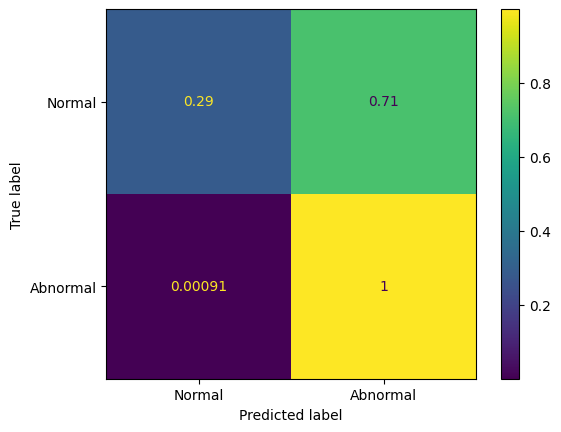

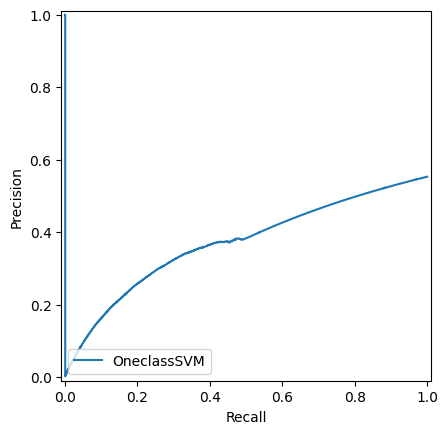

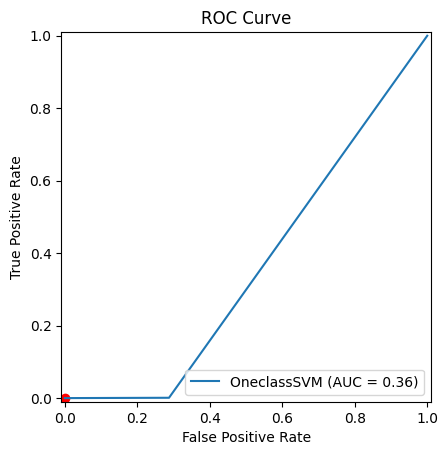

In [47]:
# Average, Precision, Recall, F1-Score
from sklearn import metrics
print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.show()

# Precision Recall Curve
Y_scores = clf.decision_function(X_test) # decision function scores because we are using OneClassSVM

prec, recall, _ = metrics.precision_recall_curve(Y_test, Y_scores, pos_label= -1)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='OneclassSVM').plot()

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(Y_test, Y_pred, pos_label= -1)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OneclassSVM')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.title("ROC Curve")
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.show()

* Average accuracy tells how many classified samples are right. Whereas balanced Accuracy takes Recall of each class into account. It is less because our normal samples are small proportion and 88% of them are misclassed.
* Precision should come to 0.53 but why 0.940662???

* High False Positive Rates that means too many Normal instances as abnormal recognized (Fp = 0.89).<br>
But the Modal identifies all abnormal instances (TP = 1). That means no abnormal samples gone unnoticed.

* The AU Curve suggests that while the model can confidently identify a small number of abnormal instances, it struggles to generalize well when trying to identify a larger number of them, leading to many false positives

## The Modal after PCA

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
clf = OneClassSVM(kernel="poly", degree= 5, nu= 0.05, gamma= 'scale')
clf.fit(X_PCA)
Y_pred = clf.predict(X_test_PCA)

### Evaluation

Average Accuracy Score: 0.6889056414122378
Balanced Accuracy Score: 0.6617937527736241
         Precision    Recall  F1-Score
Anomaly   0.656619  0.917159  0.765323


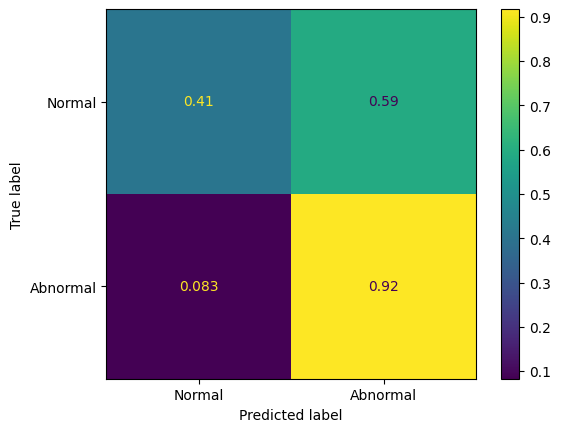

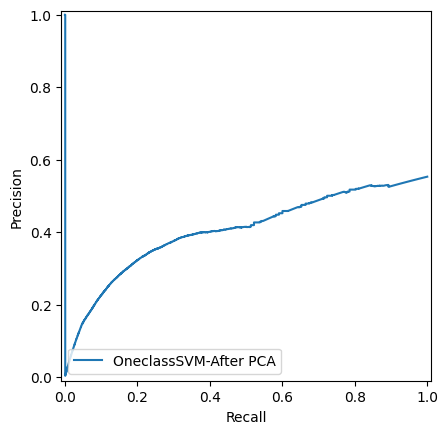

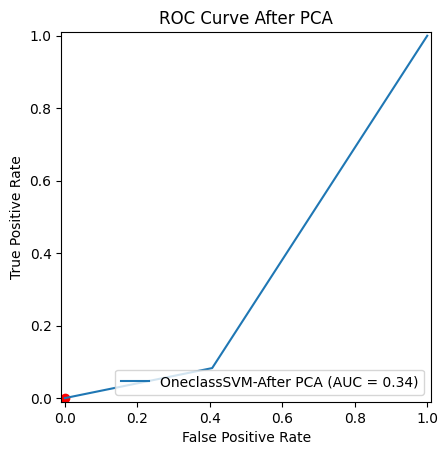

In [50]:
# Precision, Recall, F1-Score
from sklearn import metrics
print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.show()

# Precision Recall Curve
Y_scores = clf.decision_function(X_test_PCA) # decision function scores because we are using OneClassSVM

prec, recall, _ = metrics.precision_recall_curve(Y_test, Y_scores, pos_label= -1)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='OneclassSVM-After PCA').plot()

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(Y_test, Y_pred, pos_label= -1)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OneclassSVM-After PCA')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.title("ROC Curve After PCA")
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.show()

## Conclusion

One class SVM which uses Gaussian kernel to learn a boundary around the Normal only train Datasamples and with the help of 'nu' Parameter the Modal can be set for strict or soft boundary. (nu = (0, 1] )<br>

The Oneclass SVM which is used for Novelty detecetion here produced an above average results in classifying the samples from normal to abnormal. But for detecting the anomalie (Recall for abnormal sample) the modal performs good and produced same result after the PCA dimension reduction.<br>

The ROC curve shows that for small FPR only half the maximum of TPR can be achieved. which means in order to detect all the anomalies (TPR = 1) the modal have to detect almost all Normal samples falsely (FPR is not low). 